In [40]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

import lightning as L

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
inputs = torch.tensor([[1., 0., 0., 0.],
                       [0., 1., 0., 0.],
                       [0., 0., 1., 0.],
                       [0., 0., 0., 1.]])
labels = torch.tensor([[0., 1., 0., 0.],
                       [0., 0., 1., 0.],
                       [0., 0., 0., 1.],
                       [0., 1., 0., 0.]])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [42]:
class WordEmbeddingFromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()

        min_value = -0.5
        max_value = 0.5
        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.loss = nn.CrossEntropyLoss()
    
    def forward (self, input):
        input = input[0]

        inputs_to_top_hidden = ((input[0] * self.input1_w1) +
                                (input[1] * self.input2_w1) +
                                (input[2] * self.input3_w1) +
                                (input[3] * self.input4_w1))
        inputs_to_bottom_hidden = ((input[0] * self.input1_w2) + 
                                   (input[1] * self.input2_w2) + 
                                   (input[2] * self.input3_w2) + 
                                   (input[3] * self.input4_w2))
        
        output1 = ((inputs_to_top_hidden * self.output1_w1) + (inputs_to_bottom_hidden * self.output1_w2))
        output2 = ((inputs_to_top_hidden * self.output2_w1) + (inputs_to_bottom_hidden * self.output2_w2))
        output3 = ((inputs_to_top_hidden * self.output3_w1) + (inputs_to_bottom_hidden * self.output3_w2))
        output4 = ((inputs_to_top_hidden * self.output4_w1) + (inputs_to_bottom_hidden * self.output4_w2))

        output_presoftmax = torch.stack([output1, output2, output3, output4])
        return output_presoftmax

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i[0])
        return loss

Before optimization, the parameters are...
         w1        w2    token   input
0  0.239961 -0.341856   Troll2  input1
1 -0.274756 -0.005877       is  input2
2 -0.202266  0.490138    great  input3
3 -0.198650 -0.483638  Gymkata  input4


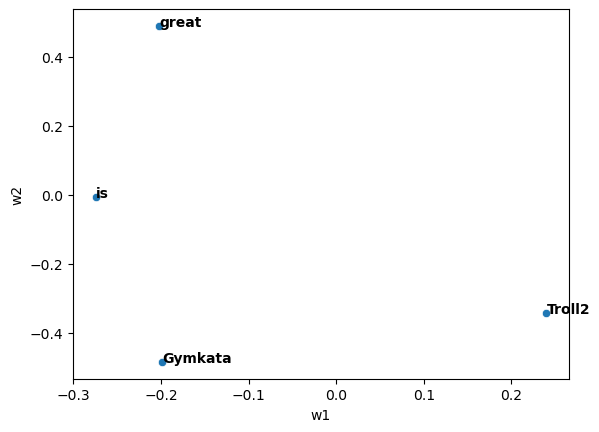

In [43]:
modelFromScratch = WordEmbeddingFromScratch()

print("Before optimization, the parameters are...")
# for name, param in modelFromScratch.named_parameters():
#     print(name, param.data)

data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
print(df)

sns.scatterplot(data=df, x="w1", y="w2")
for i in range(len(df)):
    plt.text(df.w1[i], df.w2[i], df.token[i],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\justi\.conda\envs\torch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\justi\.conda\envs\torch\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The n

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


         w1        w2    token   input
0  3.016330 -2.593639   Troll2  input1
1 -3.086339  4.056438       is  input2
2 -4.230235 -3.027759    great  input3
3  3.019428 -2.603152  Gymkata  input4


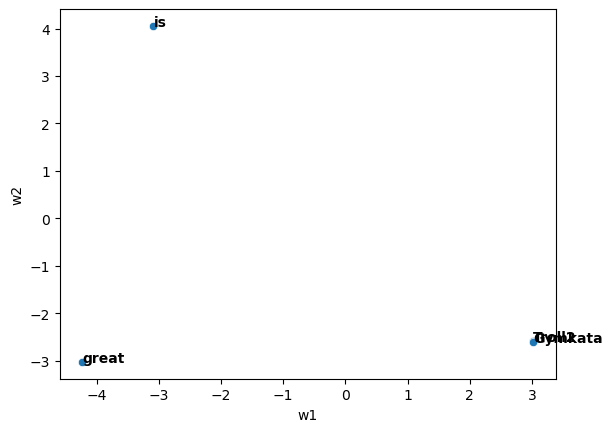

In [46]:
trainer = L.Trainer(max_epochs=100)

trainer.fit(modelFromScratch, train_dataloaders=dataloader)

data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
print(df)

sns.scatterplot(data=df, x="w1", y="w2")
for i in range(len(df)):
    plt.text(df.w1[i], df.w2[i], df.token[i],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()

In [48]:
softmax = nn.Softmax(dim=0)

print(torch.round(softmax(modelFromScratch.forward(torch.tensor([[1., 0., 0., 0.]]))), decimals=2))
print(torch.round(softmax(modelFromScratch.forward(torch.tensor([[0., 1., 0., 0.]]))), decimals=2))
print(torch.round(softmax(modelFromScratch.forward(torch.tensor([[0., 0., 1., 0.]]))), decimals=2))
print(torch.round(softmax(modelFromScratch.forward(torch.tensor([[0., 0., 0., 1.]]))), decimals=2))

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)
tensor([0., 0., 1., 0.], grad_fn=<RoundBackward1>)
tensor([0., 0., 0., 1.], grad_fn=<RoundBackward1>)
tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)


In [49]:
class WordEmbeddingWithLinear(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)

        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, input):
        hidden = self.input_to_hidden(input)
        output = self.hidden_to_output(hidden)
        return output
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i)
        return loss

         w1        w2    token   input
0  0.328932  0.351187   Troll2  input1
1 -0.237780  0.107668       is  input2
2 -0.159965  0.241246    great  input3
3 -0.089162  0.381913  Gymkata  input4


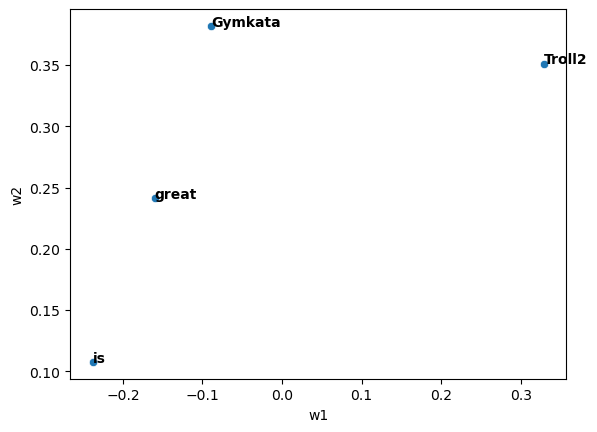

In [51]:
modelLinear = WordEmbeddingWithLinear()

data = {
    "w1": modelLinear.input_to_hidden.weight[0].detach().numpy(),
    "w2": modelLinear.input_to_hidden.weight[1].detach().numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
print(df)

sns.scatterplot(data=df, x="w1", y="w2")
for i in range(len(df)):
    plt.text(df.w1[i], df.w2[i], df.token[i],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
c:\Users\justi\.conda\envs\torch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to im

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


         w1        w2    token   input
0  1.746606  1.812801   Troll2  input1
1 -2.277680  1.700046       is  input2
2  1.770933 -2.002570    great  input3
3  1.407520  1.855501  Gymkata  input4


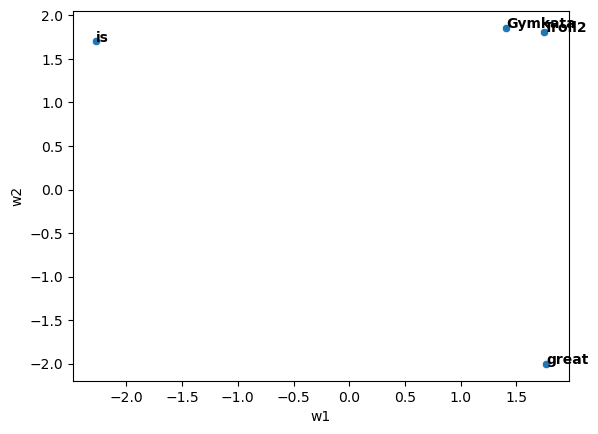

In [52]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelLinear, train_dataloaders=dataloader)

data = {
    "w1": modelLinear.input_to_hidden.weight[0].detach().numpy(),
    "w2": modelLinear.input_to_hidden.weight[1].detach().numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
print(df)

sns.scatterplot(data=df, x="w1", y="w2")
for i in range(len(df)):
    plt.text(df.w1[i], df.w2[i], df.token[i],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()

In [53]:
modelLinear.input_to_hidden.weight

Parameter containing:
tensor([[ 1.7466, -2.2777,  1.7709,  1.4075],
        [ 1.8128,  1.7000, -2.0026,  1.8555]], requires_grad=True)

In [58]:
word_embeddings = nn.Embedding.from_pretrained(modelLinear.input_to_hidden.weight.T)

vocab = {
    "Troll2": 0,
    "is": 1,
    "great": 2,
    "Gymkata": 3
}

word_embeddings(torch.tensor(vocab["is"]))

tensor([-2.2777,  1.7000])